In [2]:
import pertpy as pt
import pickle as pkl
import scanpy as sc
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
from scipy import stats
from scipy import sparse 
from statsmodels.sandbox.stats.multicomp import multipletests

import scperturb as scp

Installed version 0.4.0 of pertpy is outdated. Newest version is 0.5.0!

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
def test_association(adata, celltype_label = "Cluster", sample_label="Sample", condition_label = "Efficacy", conditions_compare = ("PR","SD")): 
    """
    Tests association between etc 
    Note: benjamini-hochberg corrects for the number of cell types, NOT the number of MCPs
    """
    
    pvals = pd.DataFrame(1, adata.obs[celltype_label].unique(), ["mcp_"+str(n) for n in range(0,10)])
    tstats = pd.DataFrame(1, adata.obs[celltype_label].unique(), ["mcp_"+str(n) for n in range(0,10)])
    pvals_adj = pd.DataFrame(1, adata.obs[celltype_label].unique(), ["mcp_"+str(n) for n in range(0,10)])
    
    response = adata.obs.groupby(sample_label)[condition_label].agg(pd.Series.mode)
    res = dict()
    for celltype in adata.obs[celltype_label].unique():
        df = adata.obs[adata.obs[celltype_label]==celltype]

        for mcpnum in ["mcp_"+str(n) for n in range(0,10)]:
            mns = df.groupby(sample_label)[mcpnum].mean()
            mns = pd.concat([mns,response],axis=1)
            res = stats.ttest_ind(mns[mns[condition_label]==conditions_compare[0]][mcpnum],mns[mns[condition_label]==conditions_compare[1]][mcpnum])
            pvals.loc[celltype, mcpnum]=res[1]
            tstats.loc[celltype, mcpnum]=res[0]
            #return(res)
            #
    for mcpnum in ["mcp_"+str(n) for n in range(0,10)]:
        pvals_adj[mcpnum]=multipletests(pvals[mcpnum], method='fdr_bh')[1]
    return pvals,tstats,pvals_adj

In [2]:
adata=sc.read_h5ad("output/tumor_pre_DLG_normalizeTrue_bssolver_071023.h5ad")

with open("output/tumor_pre_DLG_normalizeTrue_bssolver_071023.pkl", 'rb') as file:
    a = pkl.load(file)
file.close()


In [7]:
a['pvals_adj'] = test_association(adata)[2]# interested in MCP_4, MCP_8

In [12]:

mini = adata[adata.obs["Cluster"].isin(a['pvals_adj'][a['pvals_adj']['mcp_4']< 0.03].index.values)].copy()

In [11]:
a['pvals_adj']['mcp_4']

t_Bmem-CD27         0.021844
t_CD4_Tcm-LMNA      0.021844
t_CD4_Treg-FOXP3    0.031923
t_CD8_MAIT-KLRB1    0.021844
t_CD8_Tem-GZMK      0.031923
t_CD8_Trm-ZNF683    0.031923
t_Tn-LEF1           0.021844
t_mono-FCN1         0.079806
t_pB-IGHG1          0.021844
Name: mcp_4, dtype: float64

In [14]:
mini.obs['Cluster'].unique()

['t_Bmem-CD27', 't_CD4_Tcm-LMNA', 't_CD8_MAIT-KLRB1', 't_Tn-LEF1', 't_pB-IGHG1']
Categories (5, object): ['t_Bmem-CD27', 't_CD4_Tcm-LMNA', 't_CD8_MAIT-KLRB1', 't_Tn-LEF1', 't_pB-IGHG1']

In [47]:
celltype_objs = dict()
for celltype in adata.obs['Cluster'].unique():
    celltype_objs[celltype] = adata[adata.obs['Cluster']==celltype].copy()
    celltype_objs[celltype] = scp.equal_subsampling(celltype_objs[celltype], obs_key = "Efficacy")

In [48]:
celltype_objs

{'t_Bmem-CD27': AnnData object with n_obs × n_vars = 1154 × 4000
     obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster', 'mcp_0', 'mcp_1', 'mcp_2', 'mcp_3', 'mcp_4', 'mcp_5', 'mcp_6', 'mcp_7', 'mcp_8', 'mcp_9'
     obsm: 'X_pca', 'X_umap',
 't_CD4_Tcm-LMNA': AnnData object with n_obs × n_vars = 3524 × 4000
     obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster', 'mcp_0', 'mcp_1', 'mcp_2', 'mcp_3', 'mcp_4', 'mcp_5', 'mcp_6', 'mcp_7', 'mcp_8', 'mcp_9'
     obsm: 'X_pca', 'X_umap',
 't_CD4_Treg-FOXP3': AnnData object with n_obs × n_vars = 3274 × 4000
     obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster', 'mcp_0', 'mcp_1', 'mcp_2', 'mcp_3', 'mcp_4', 'mcp_5', 'mcp_6', 'mcp_7', 'mcp_8', 'mcp_9'
     obsm: 

In [49]:
# check if an anndata object has multiple values in adata.obs[Efficacy]
# if not remove it from the list
for celltype in celltype_objs.keys():
    if len(celltype_objs[celltype].obs['Efficacy'].unique()) == 1:
        print(celltype)

In [51]:
ct_etests = dict()
for ct in celltype_objs:
    ct_etests[ct]=  scp.etest(celltype_objs[ct], obs_key = "Efficacy",control ="SD" )

100%|██████████| 1000/1000 [00:08<00:00, 124.98it/s]


In [55]:
# create a dataframe where the rows are cell types and the columns are the edist value 
# where the edist value is taken from the cell type's entry in ct_etests

edist_df = pd.DataFrame(index = ct_etests.keys(), columns = ["edist"])
for ct in ct_etests.keys():
    edist_df.loc[ct,"edist"] = ct_etests[ct].loc['PR','edist']

<Axes: title={'center': 'edist values for each cell type'}>

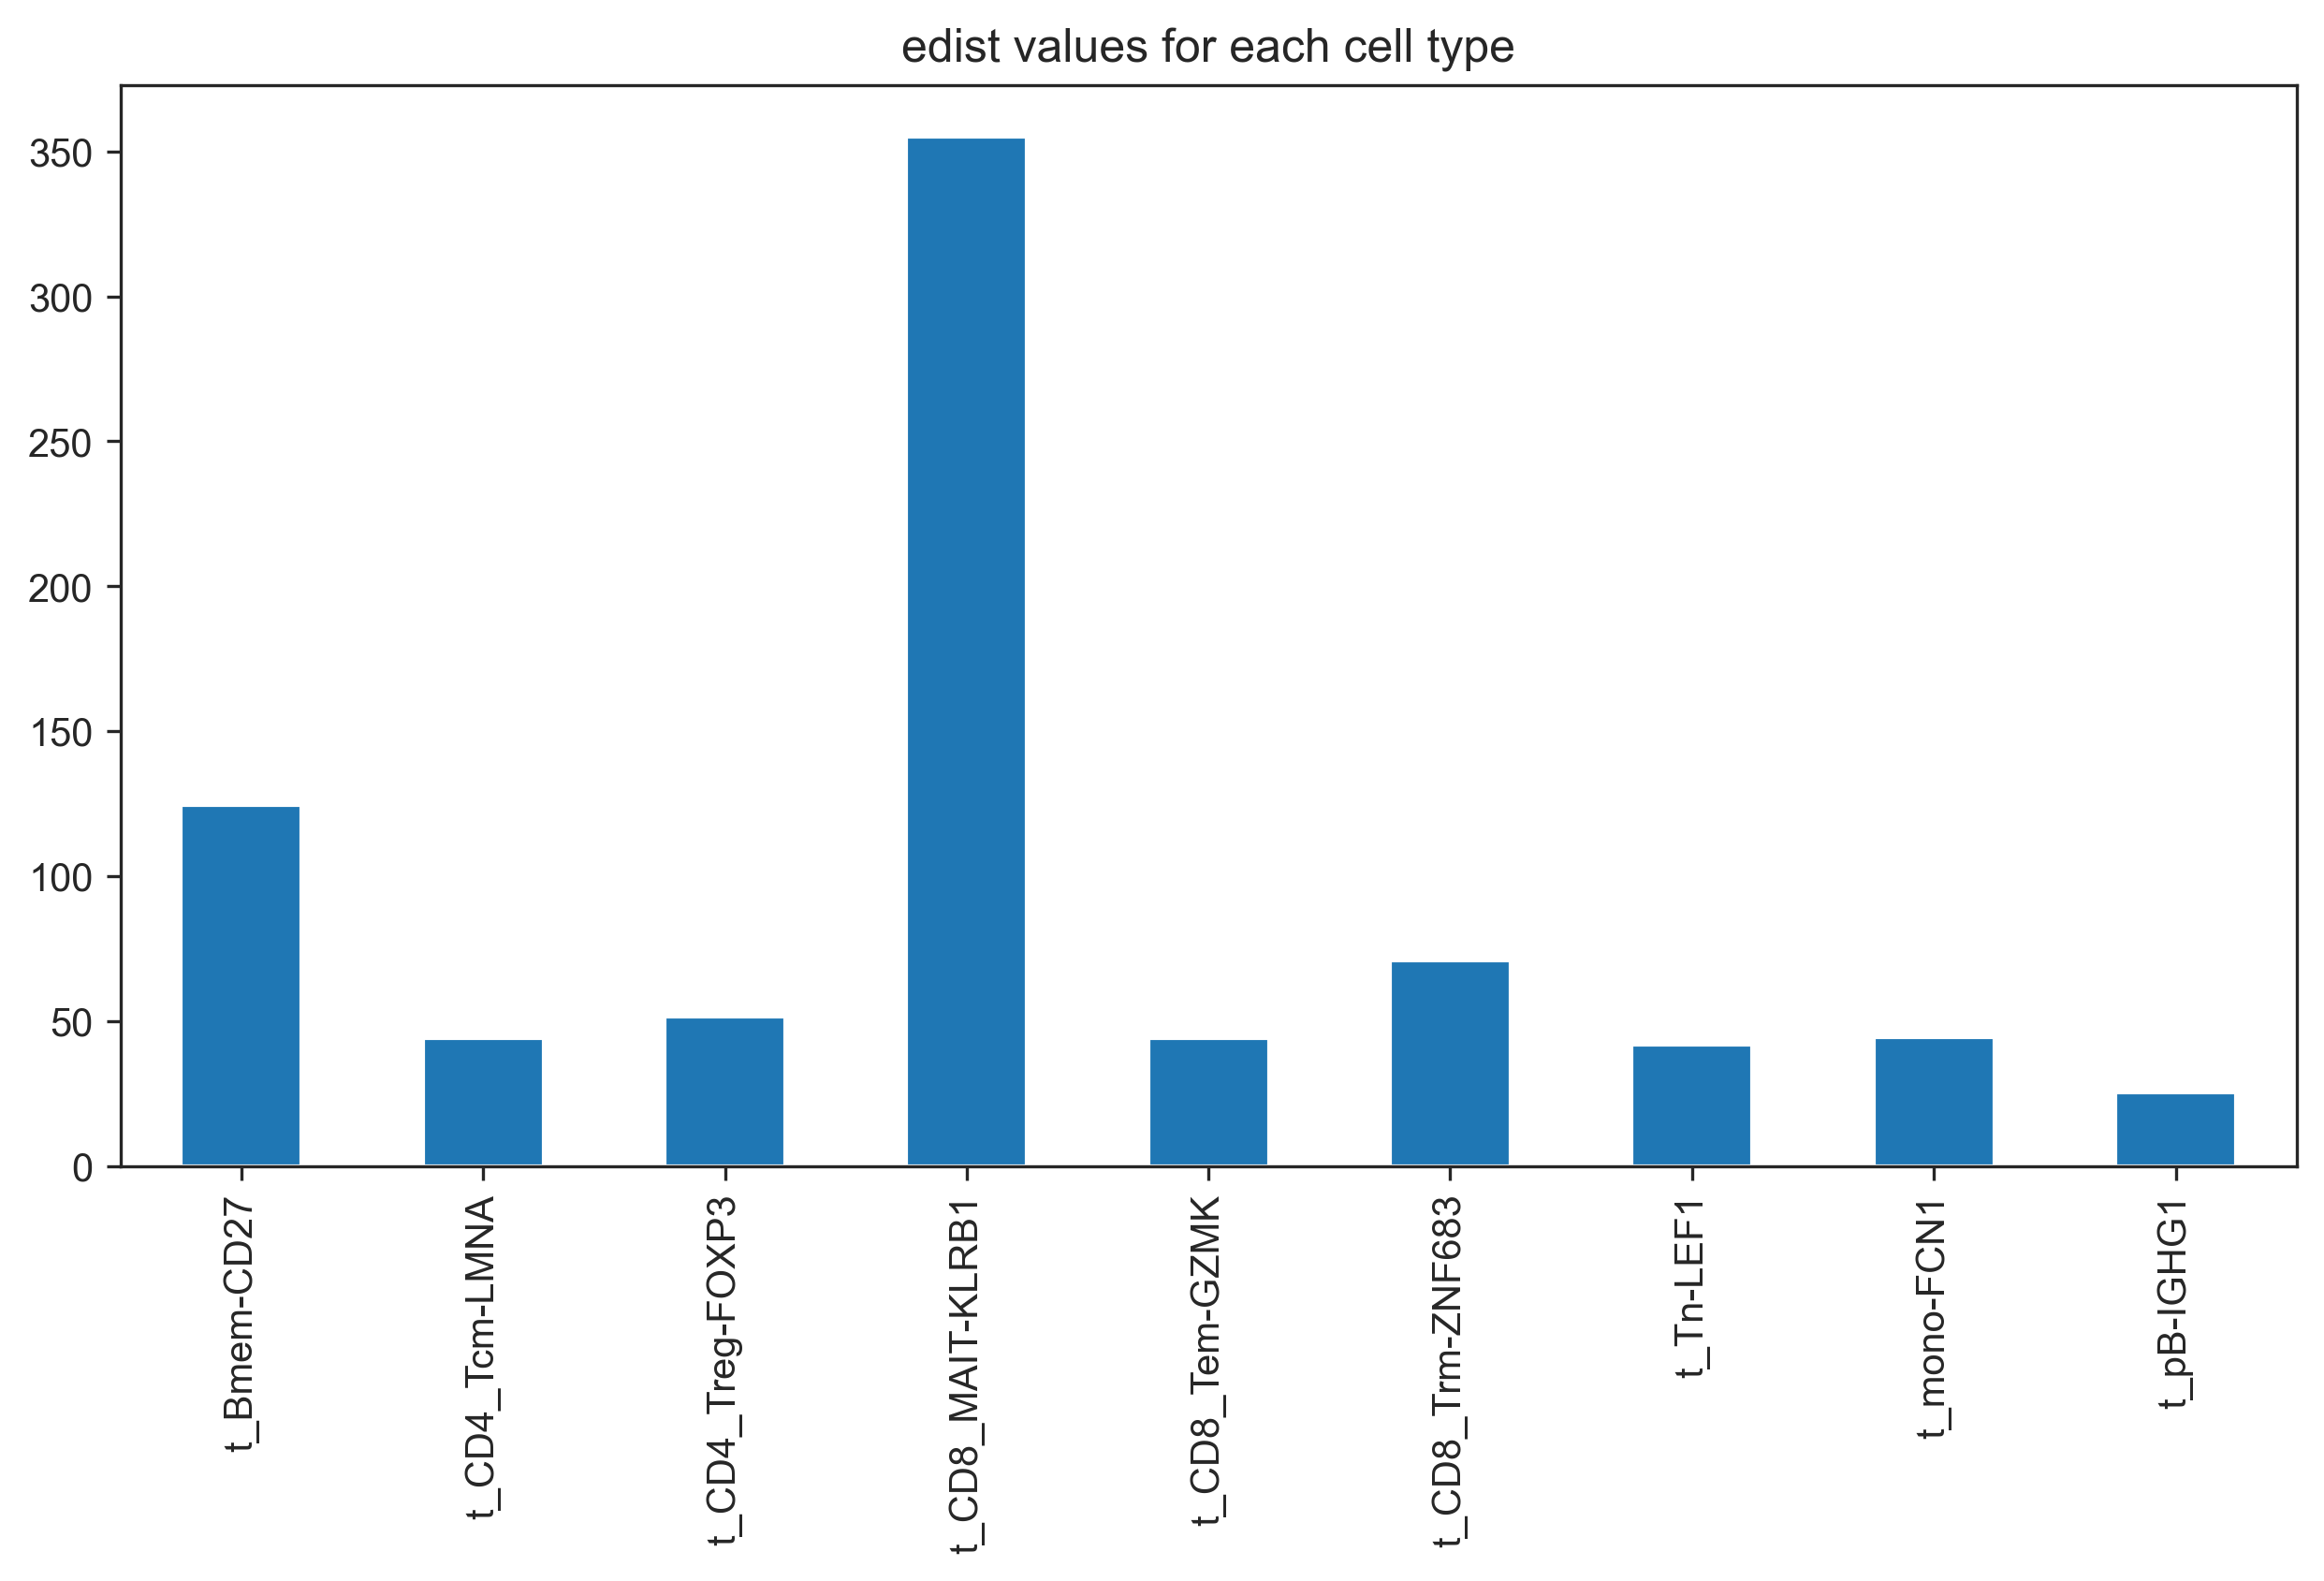

In [57]:
# plot the column edist of edist_df 
# this is the edist value for each cell type
# the cell types are ordered by their edist value

edist_df.plot.bar(y = "edist", figsize = (10,5), legend = False, title = "edist values for each cell type")

In [60]:
# what are we trying to show here? 
# for each of the 5 cell types of interest, are responder/non-responder cells statistically significantly different from each other
edist_df.to_csv("output/Edist_PR_to_SD_by_celltype.csv")
# then if those are/aren't, also test the extrema cells and (ideally) show that they *are* statistically significantly different


In [30]:
ct_etests_small = ct_etests # from mini  no subsampling stash

In [40]:
adata = sc.read_h5ad("zhang_with_PCs.h5ad")
adata = adata[adata.obs.Group == "Pre-treatment",:]

In [41]:
adata = adata[adata.obs["Origin"]=='t',:]

In [42]:
adata.obs["Cluster"].value_counts().shape

(57,)

In [52]:
celltype_objs = dict()
for celltype in adata.obs['Cluster'].unique():
    celltype_objs[celltype] = adata[adata.obs['Cluster']==celltype].copy()
    celltype_objs[celltype] = scp.equal_subsampling(celltype_objs[celltype], obs_key = "Efficacy")
    celltype_objs[celltype] = scp.equal_subsampling(celltype_objs[celltype], obs_key = "Treatment")
    # maybe try running with equal treatment sizes?

In [53]:
celltype_objs

{'t_Tn-LEF1': AnnData object with n_obs × n_vars = 2200 × 4000
     obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster'
     var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
     uns: 'hvg', 'log1p', 'pca'
     obsm: 'X_pca'
     varm: 'PCs',
 't_ILC1-IL32': AnnData object with n_obs × n_vars = 78 × 4000
     obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster'
     var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
     uns: 'hvg', 'log1p', 'pca'
     obsm: 'X_pca'
     varm: 'PCs',
 't_CD8_Tem-GZMK': AnnData object with n_obs × n_vars = 4080 × 4000
     obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Maj

In [54]:
cts = list(celltype_objs.keys())
for celltype in cts:
    if len(celltype_objs[celltype].obs['Efficacy'].unique()) == 1:
        celltype_objs.pop(celltype)

In [55]:
ct_etests = dict()
for ct in celltype_objs:
    ct_etests[ct]=  scp.etest(celltype_objs[ct], obs_key = "Efficacy",control ="SD" )
    

100%|██████████| 1000/1000 [00:00<00:00, 2010.75it/s]


In [56]:
edist_df_old = edist_df.copy()
edist_df = pd.DataFrame(index = ct_etests.keys(), columns = ["edist","pvalue"])
for ct in ct_etests.keys():
    edist_df.loc[ct,"edist"] = ct_etests[ct].loc['PR','edist']
    edist_df.loc[ct,"pvalue"] = ct_etests[ct].loc['PR','pvalue']

<Axes: title={'center': 'edist values for each cell type'}>

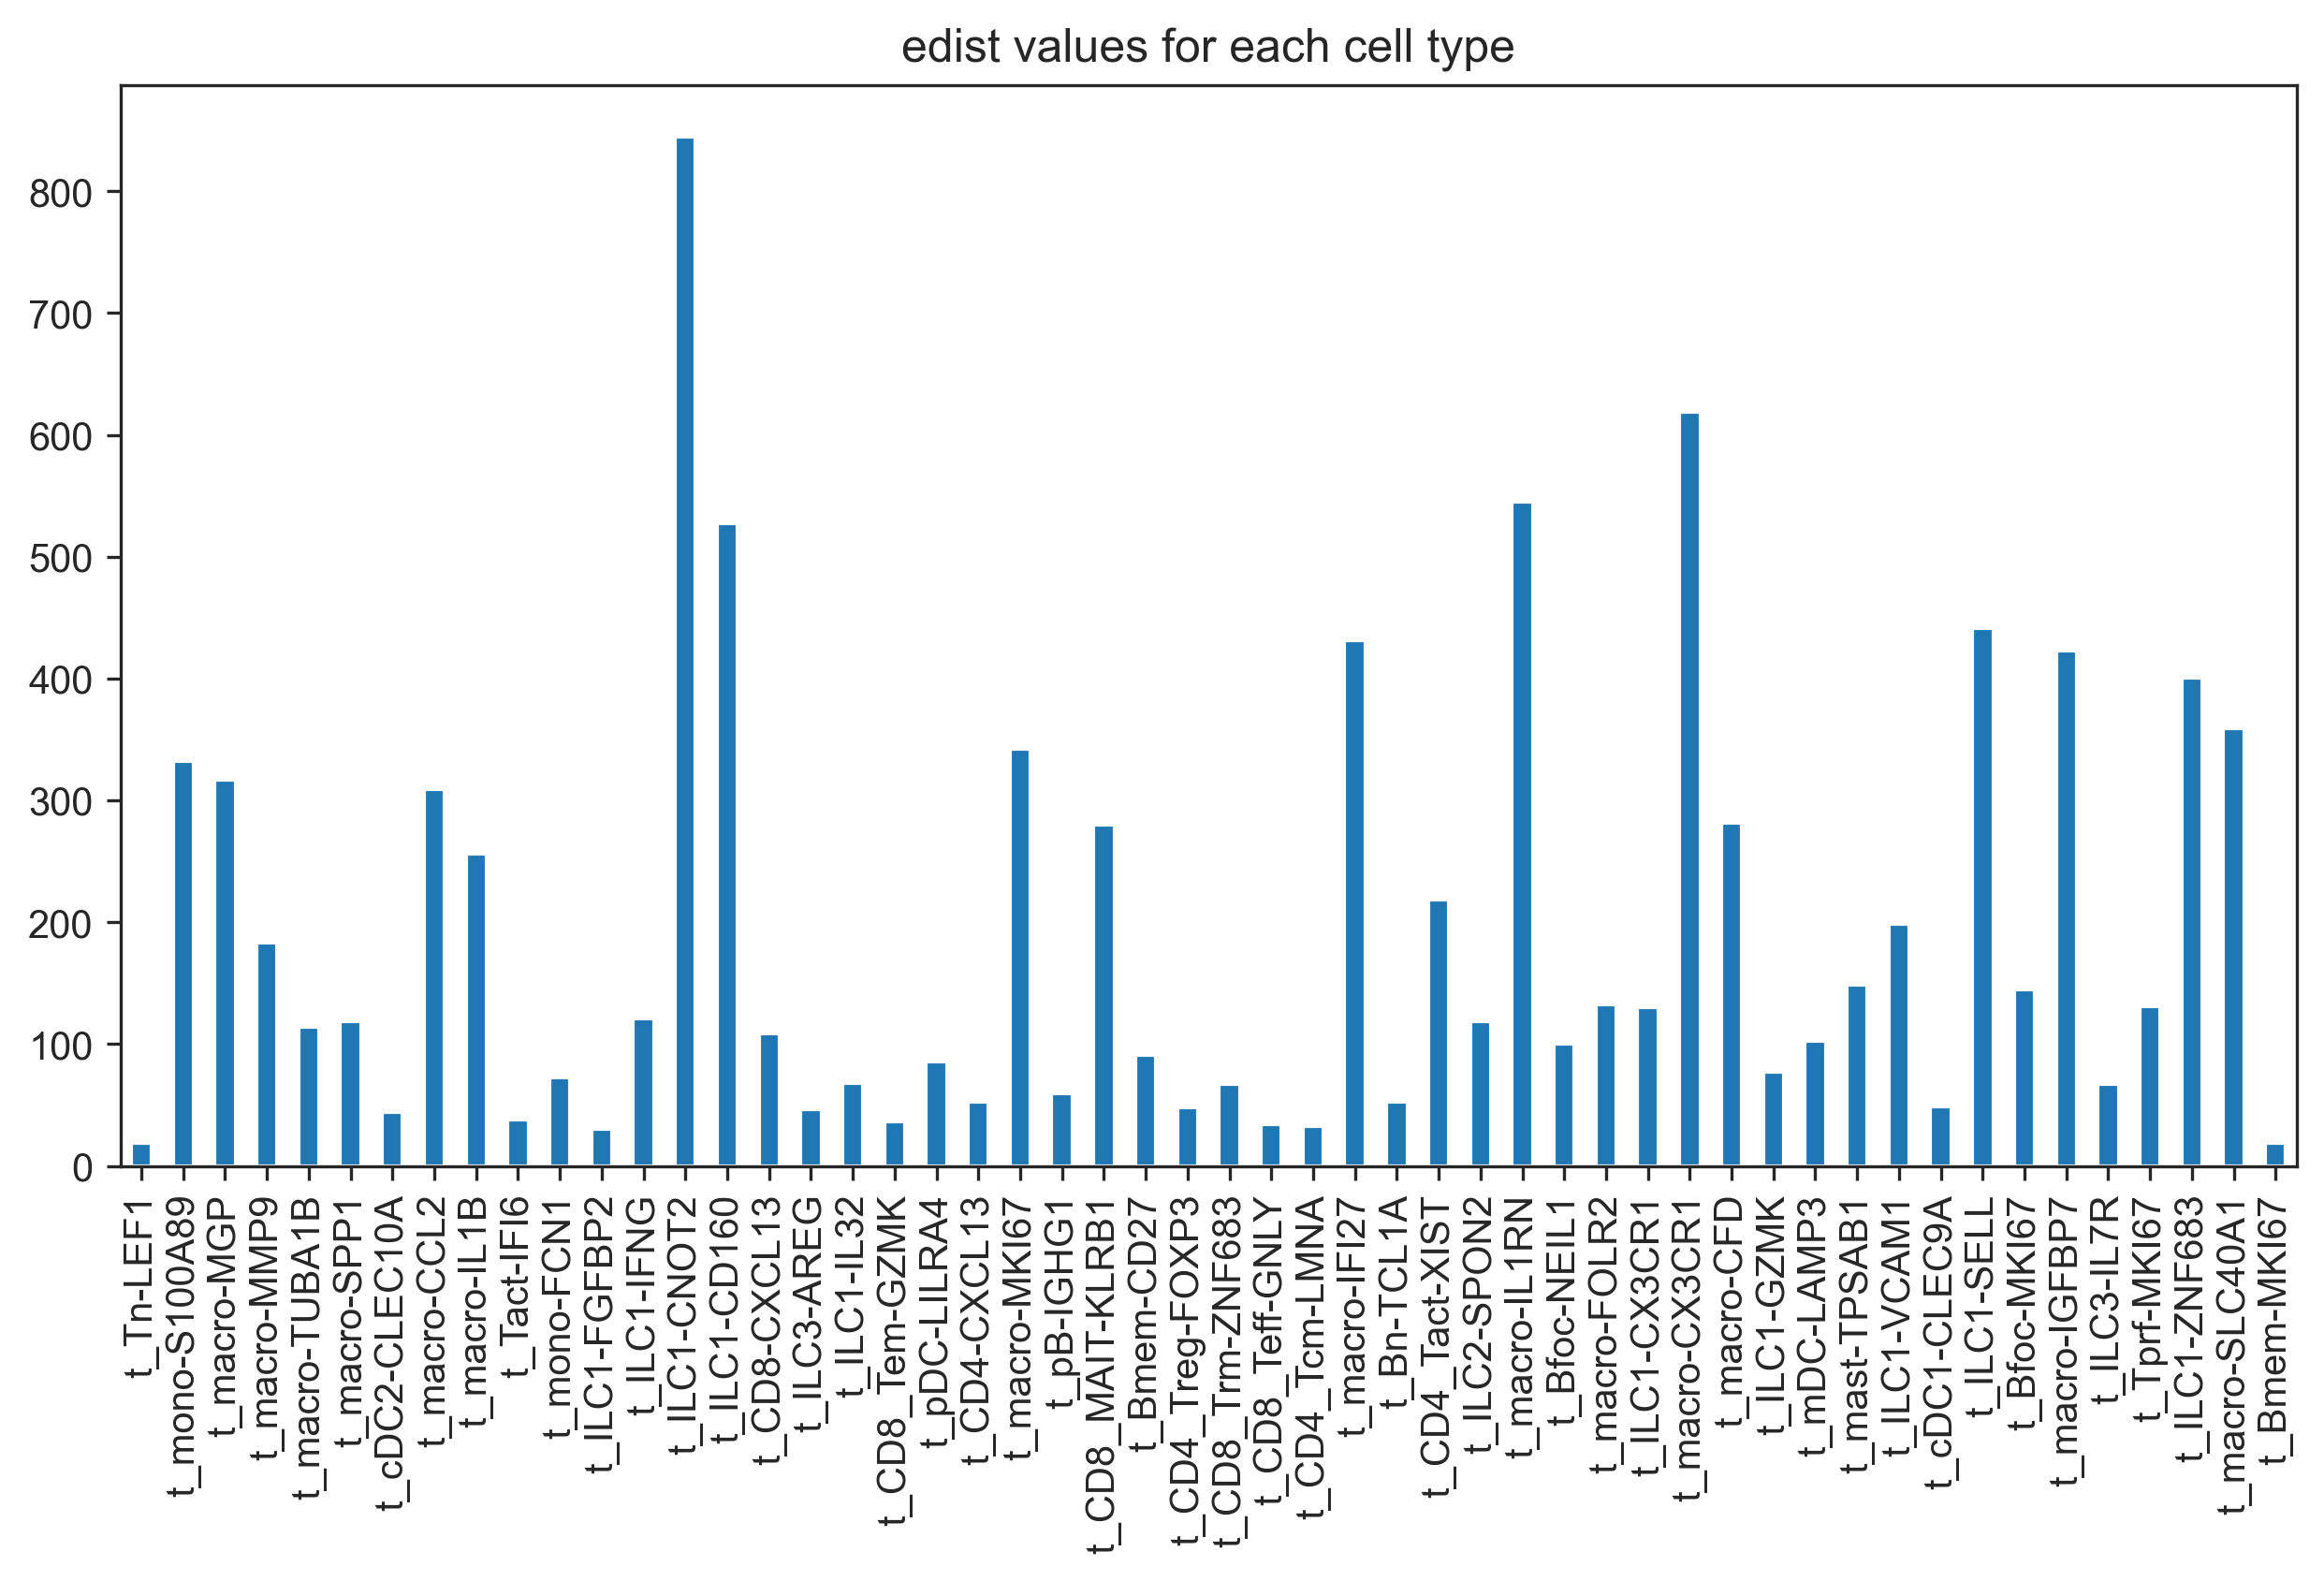

In [63]:
edist_df.sort_values("pvalue").plot(y = "edist", kind = "bar", figsize = (10,5), legend = False, title = "edist values for each cell type")

<Axes: title={'center': 'Distinguishability values for each cell type'}>

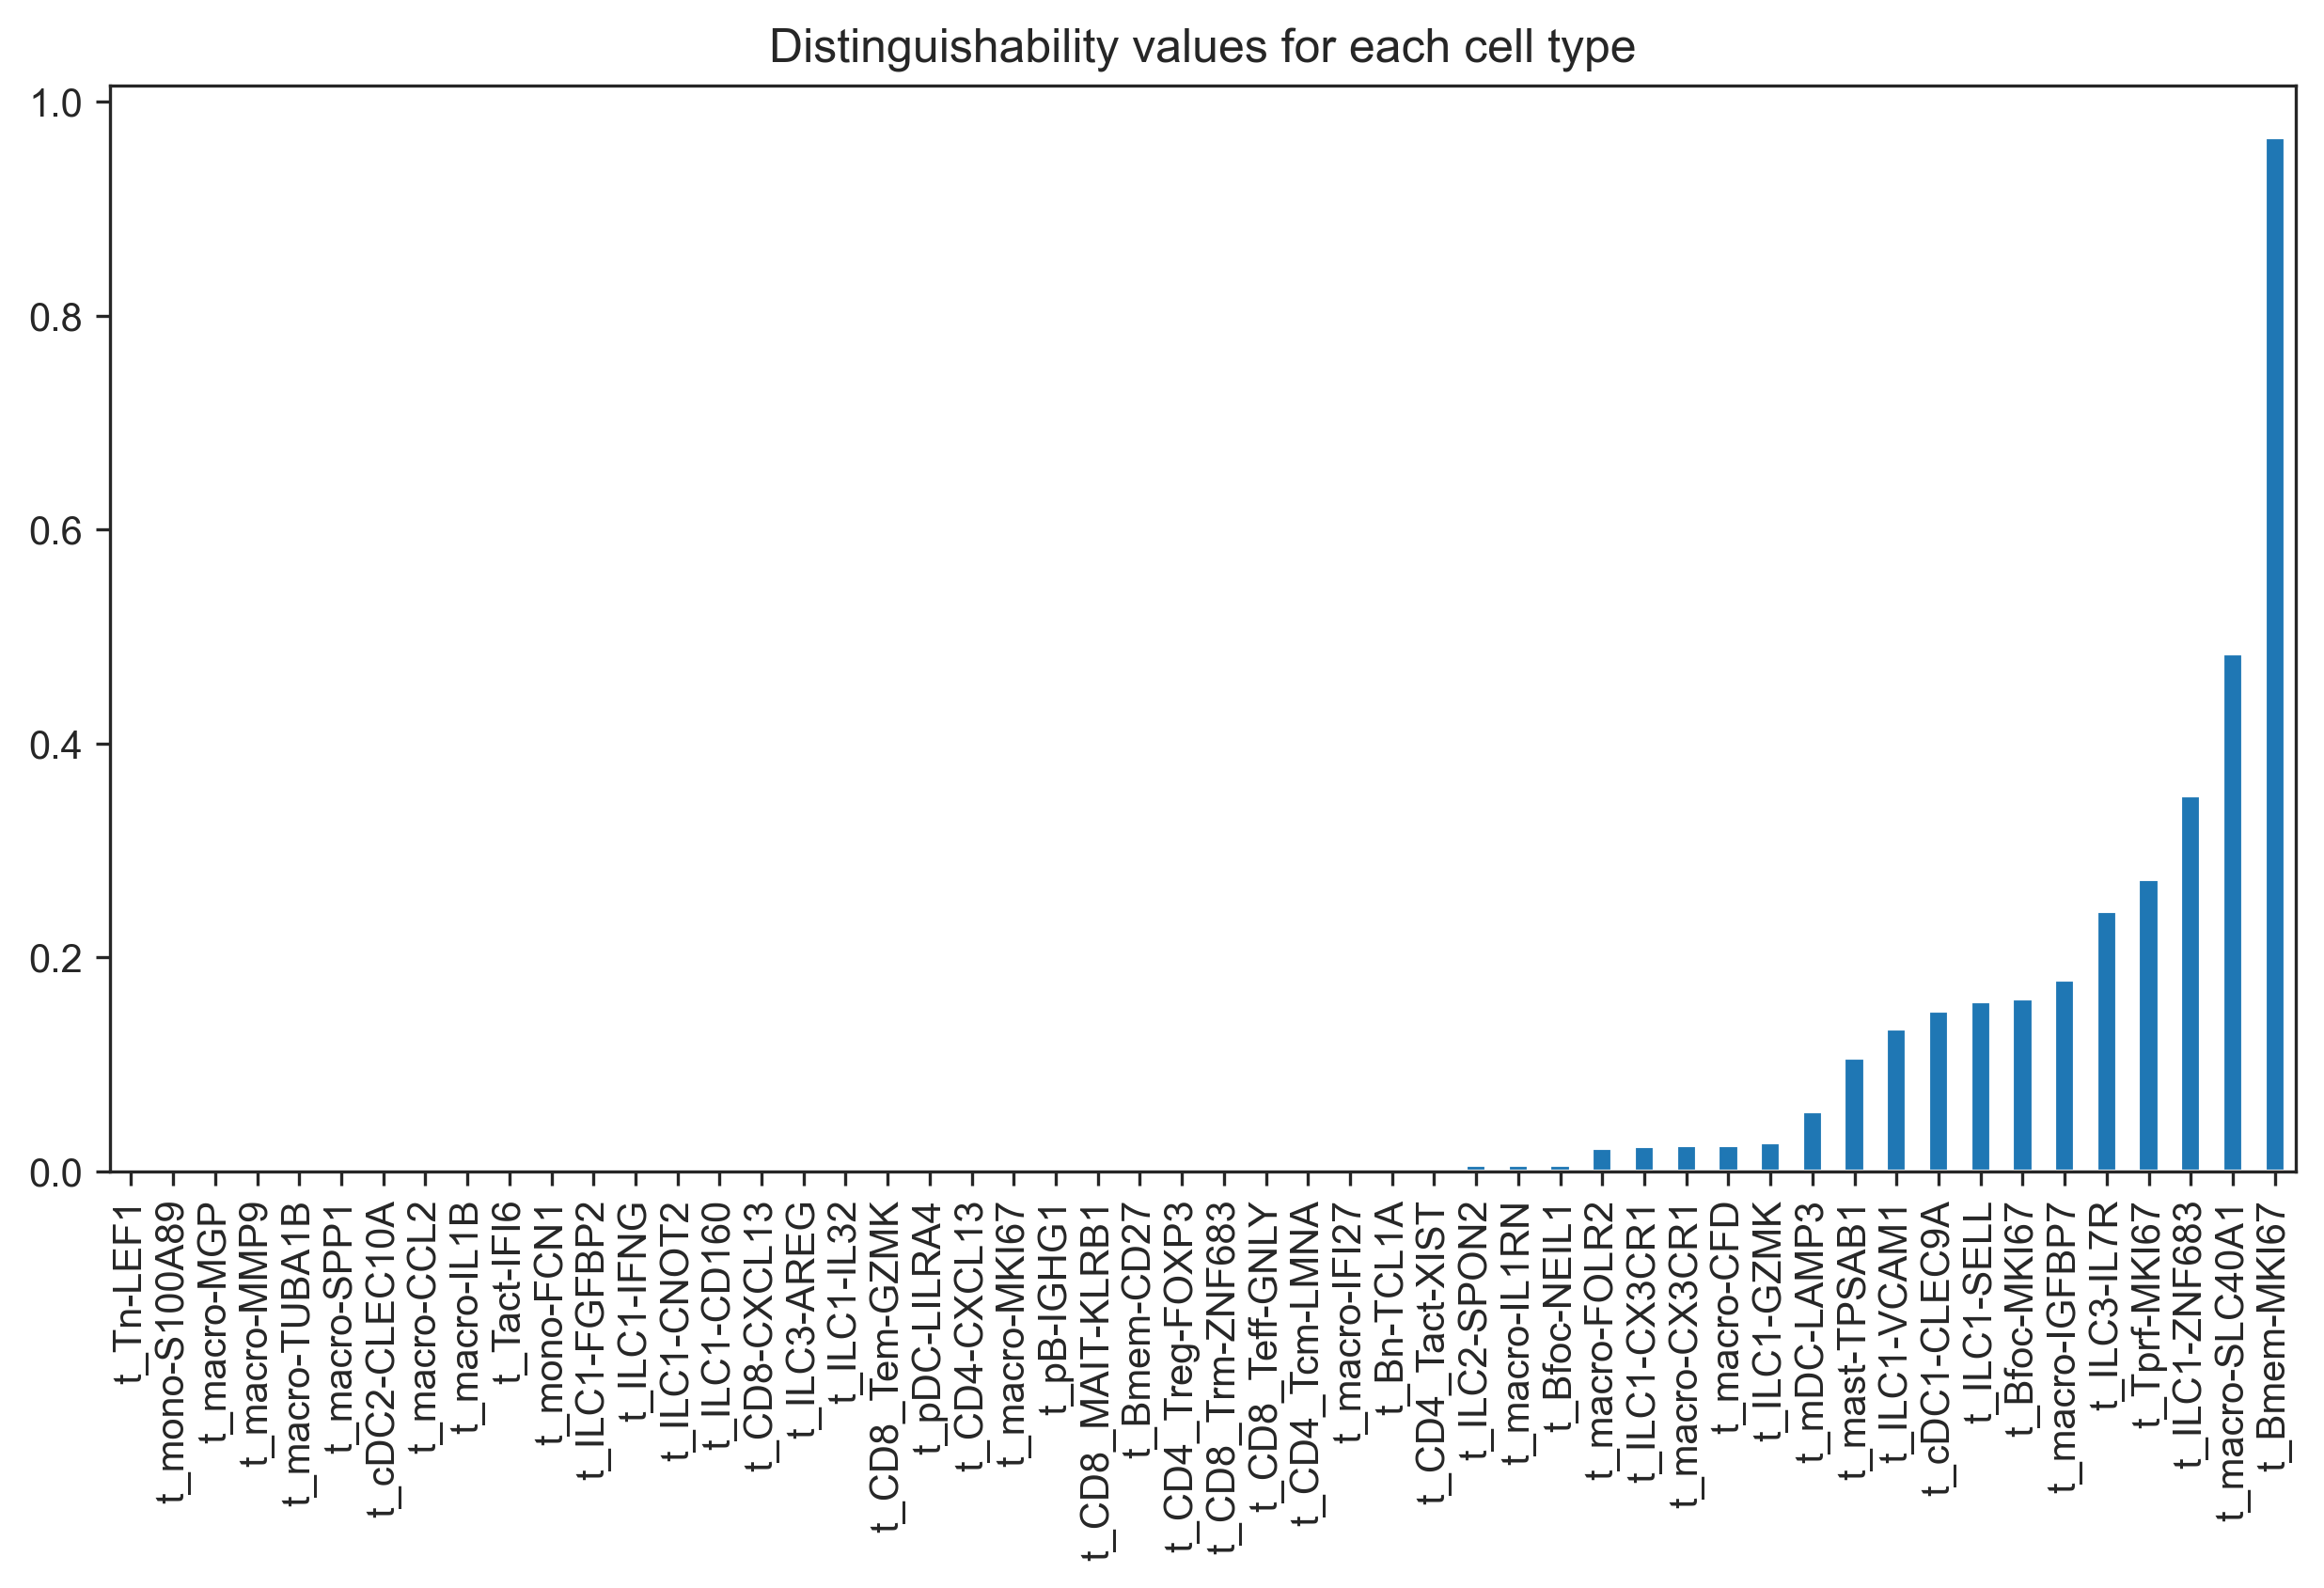

In [62]:
edist_df.sort_values("pvalue").plot(y = "pvalue", kind = "bar", figsize = (10,5), legend = False, title = "Distinguishability values for each cell type")

<Axes: xlabel='edist', ylabel='pvalue'>

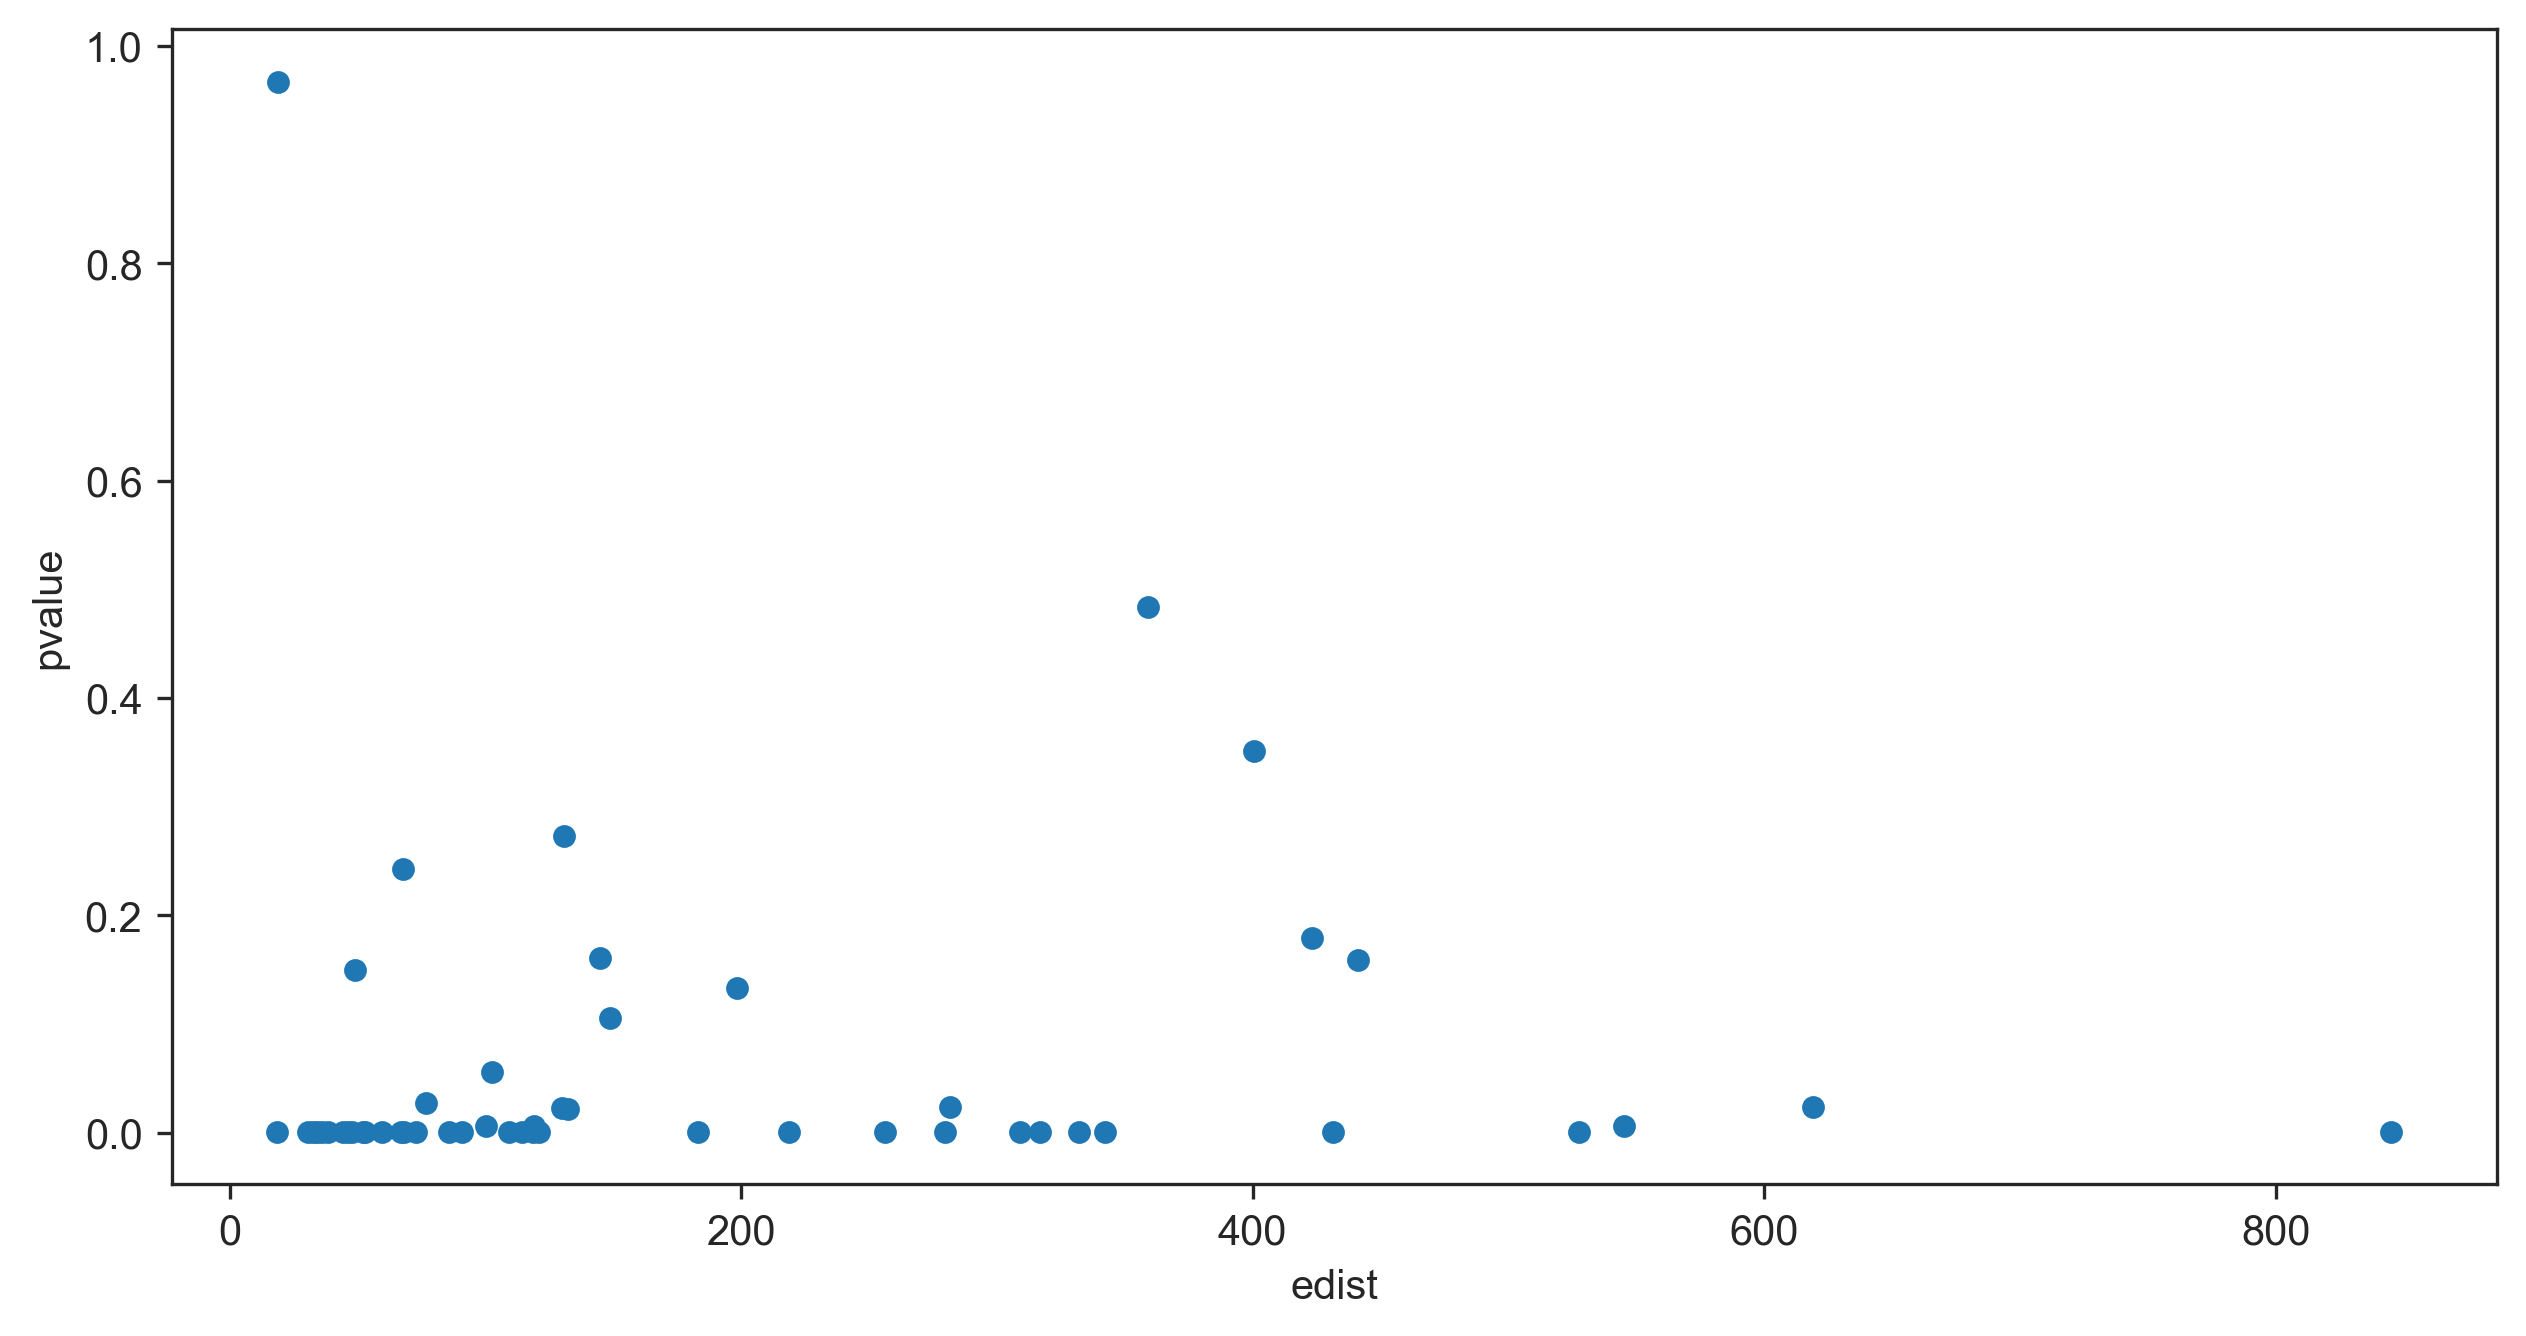

In [60]:
edist_df.plot(x="edist", y="pvalue", kind = "scatter", figsize = (10,5), legend = True)

In [83]:
adata = adata[adata.obs['Cluster']!="Mix", :]


In [84]:

sc.pp.neighbors(adata)
sc.tl.umap(adata)

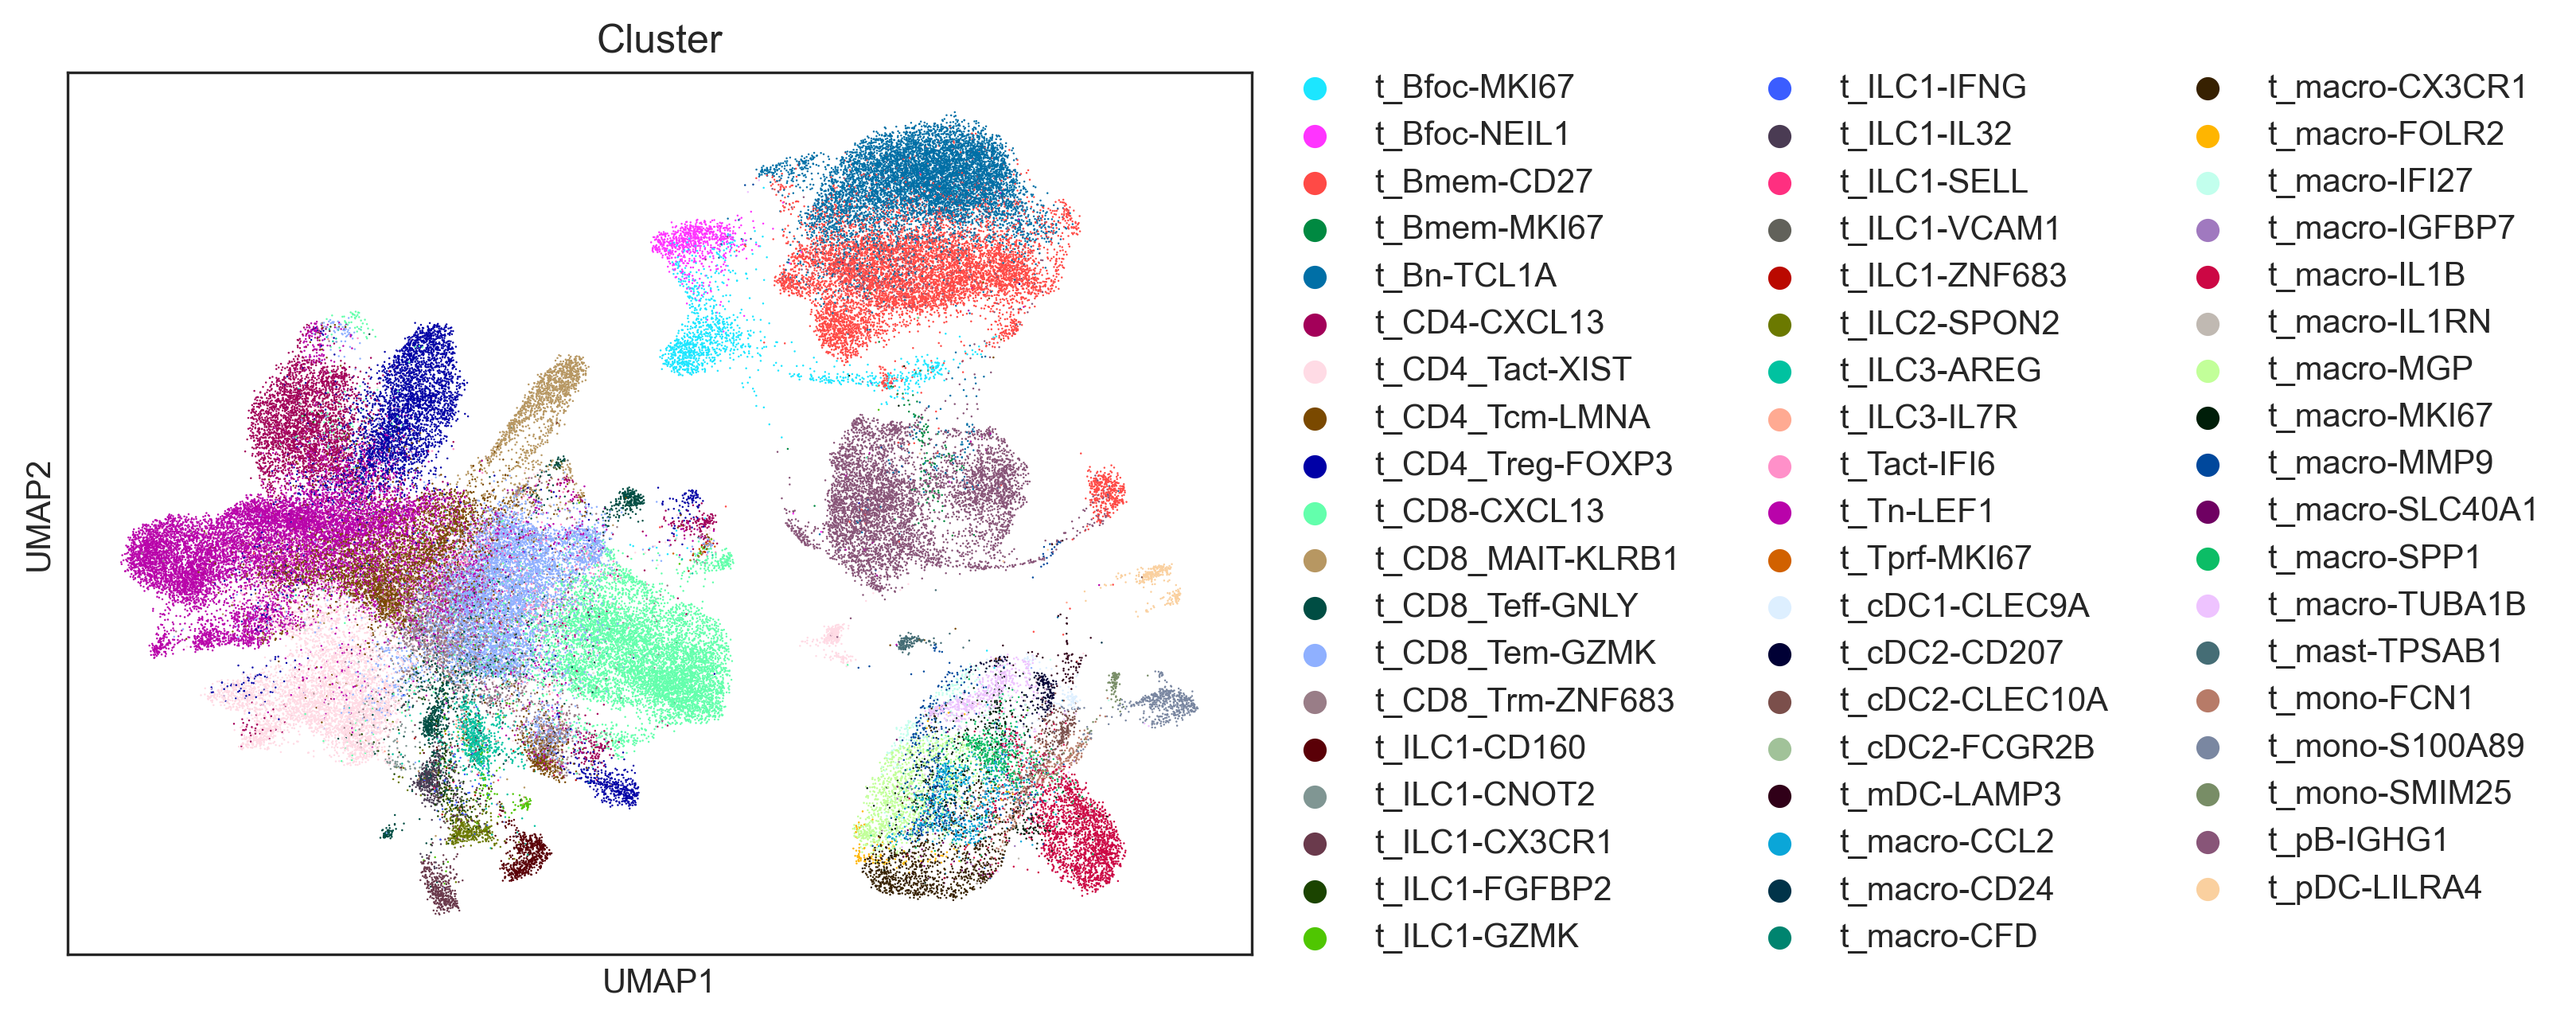

In [85]:
sc.pl.umap(adata, color="Cluster")

In [80]:
adata.obs['Cell type'] = adata.obs['Cluster'].str.split("_",expand=True)[1].str.split("-",expand=True)[0]

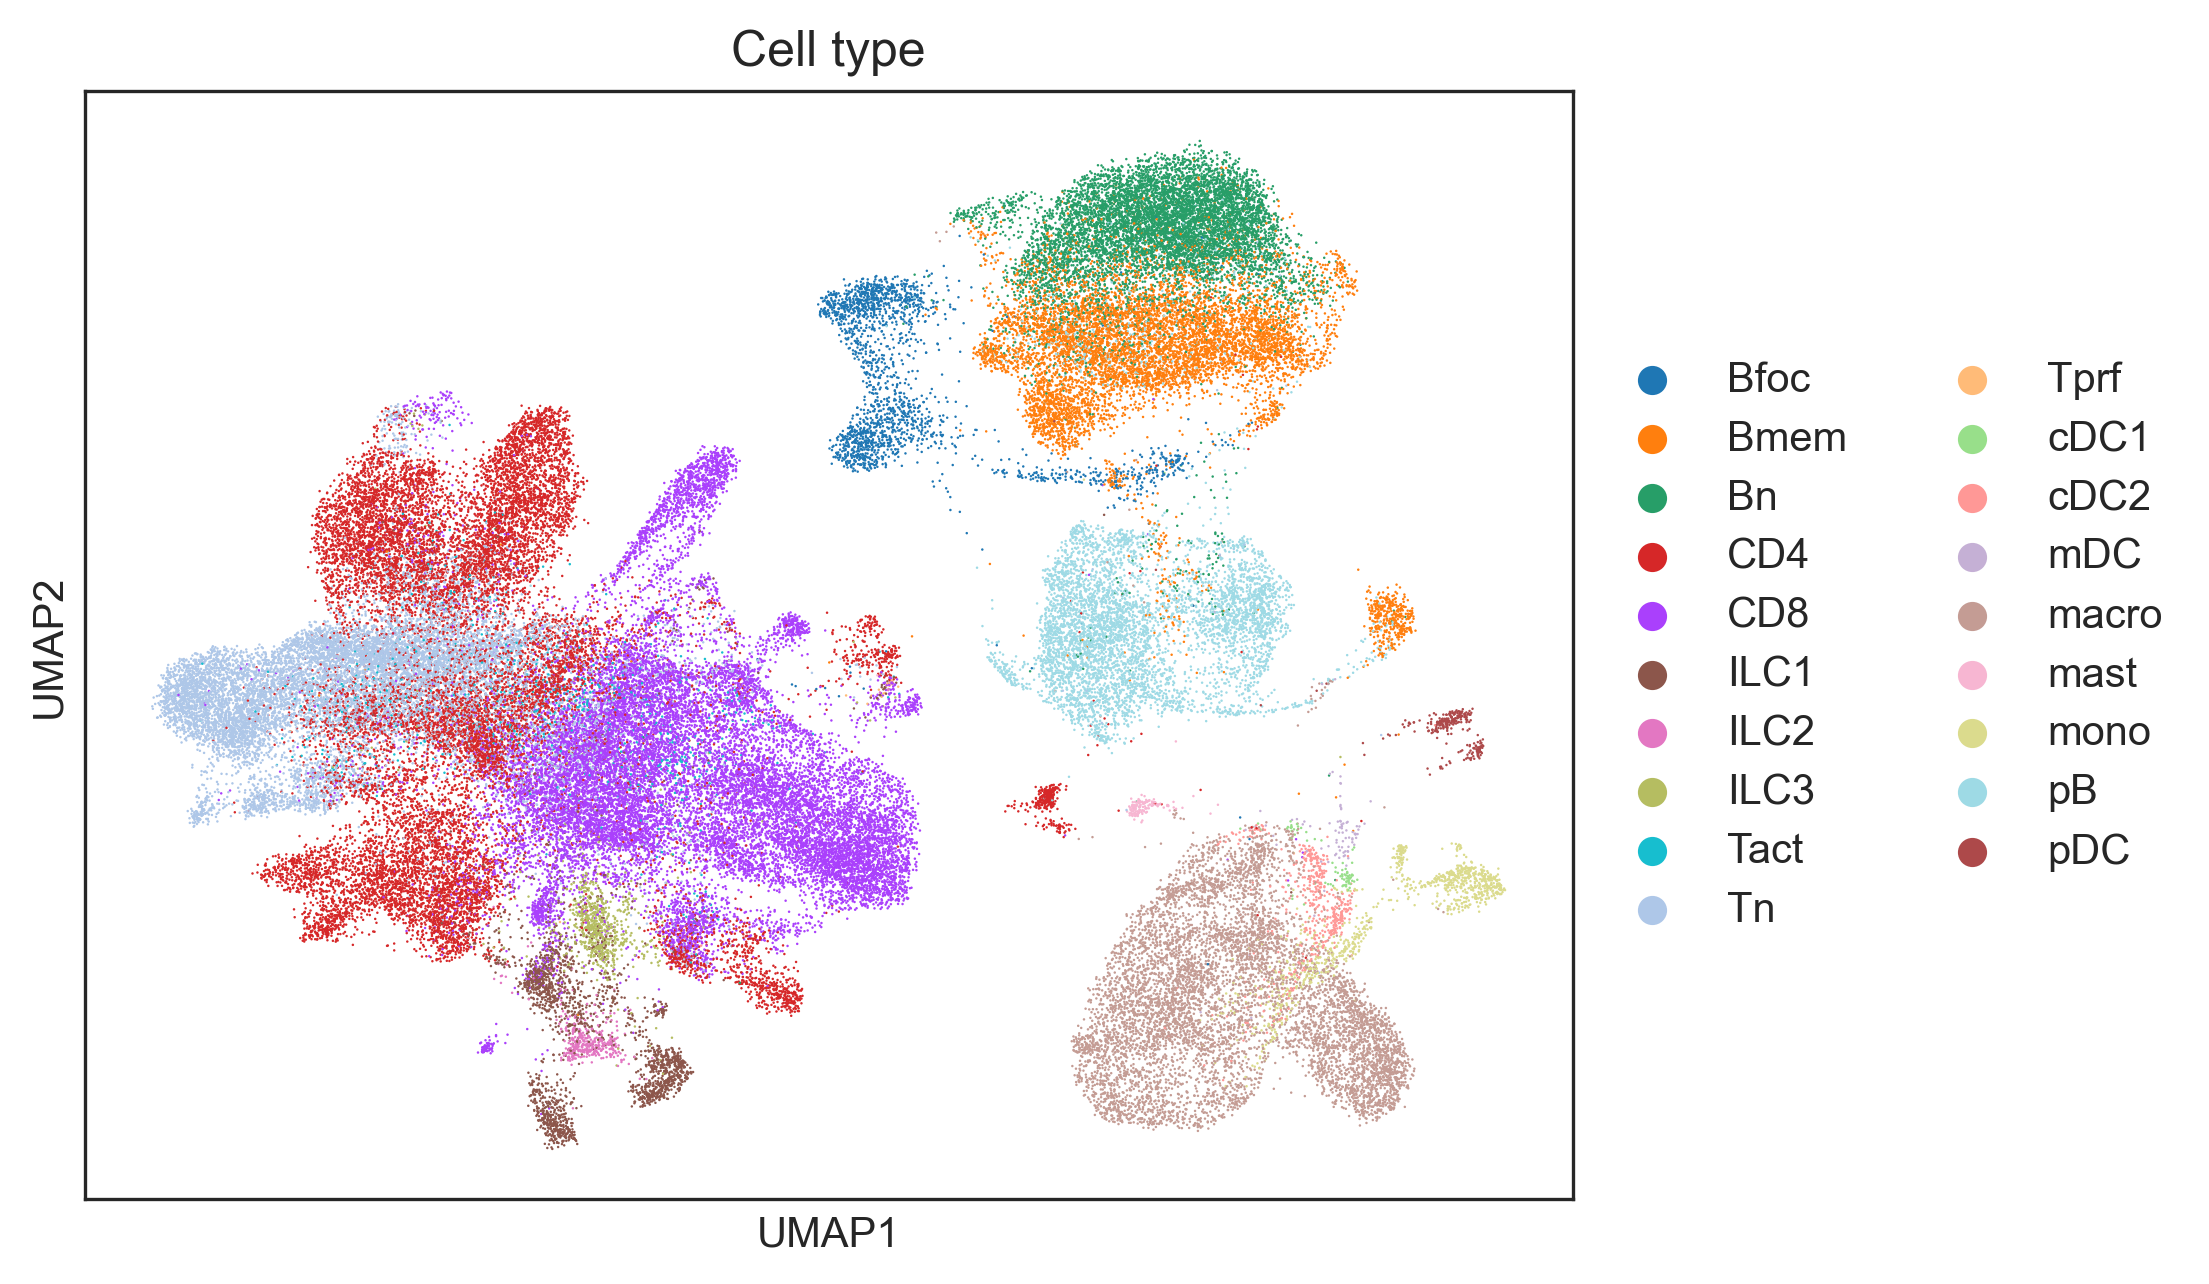

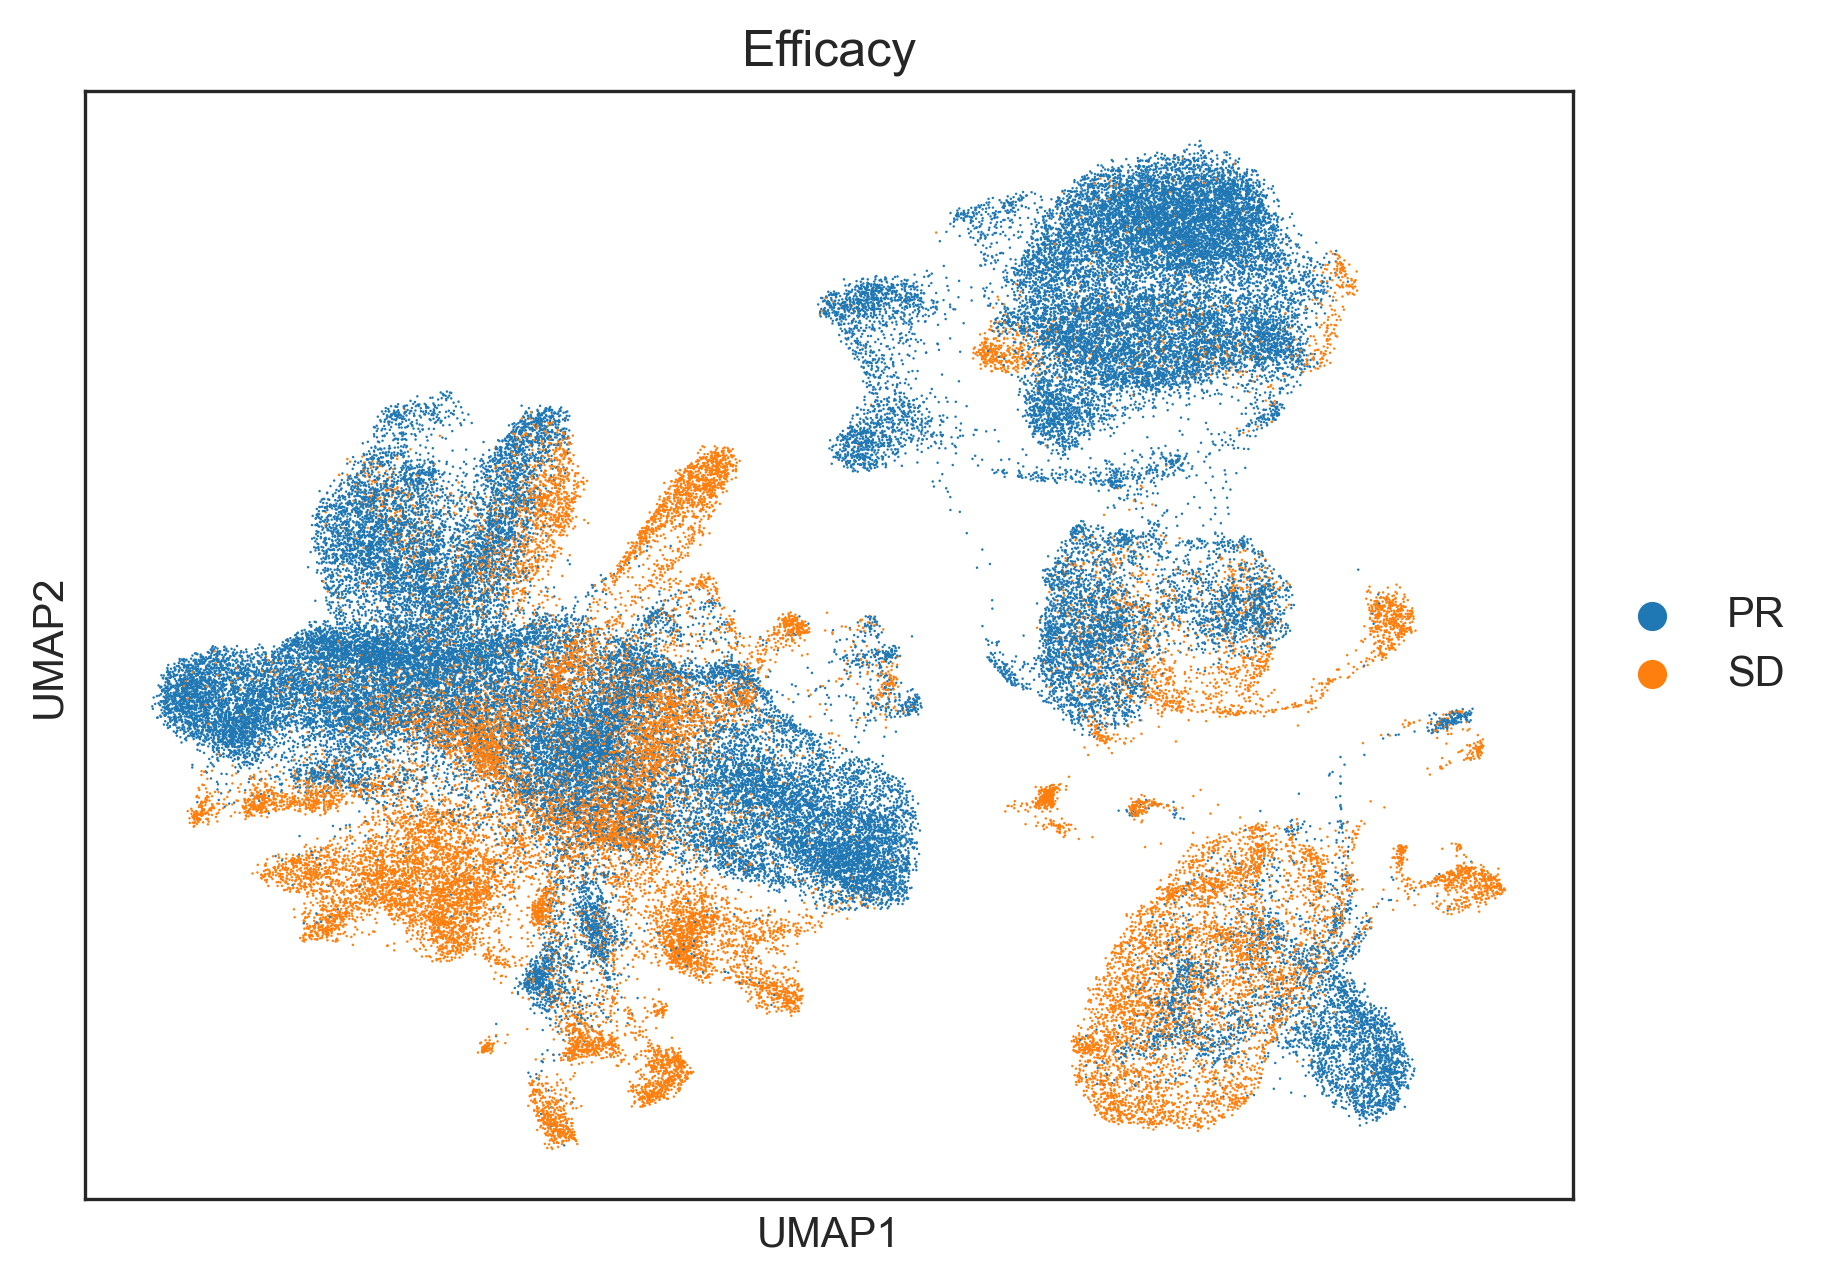

In [86]:
sc.pl.umap(adata, color="Cell type")
# highlight cells from patients who responded to treatment
sc.pl.umap(adata, color="Efficacy")

In [88]:
celltype_objs = dict()
for celltype in adata.obs['Cell type'].unique():
    celltype_objs[celltype] = adata[adata.obs['Cell type']==celltype].copy()
    celltype_objs[celltype] = scp.equal_subsampling(celltype_objs[celltype], obs_key = "Efficacy")
    celltype_objs[celltype] = scp.equal_subsampling(celltype_objs[celltype], obs_key = "Treatment")
    # maybe try running with equal treatment sizes?

In [89]:
cts = list(celltype_objs.keys())
for celltype in cts:
    if len(celltype_objs[celltype].obs['Efficacy'].unique()) == 1:
        celltype_objs.pop(celltype)

In [90]:
celltype_objs

{'Tn': AnnData object with n_obs × n_vars = 2242 × 4000
     obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster', 'Cell type'
     var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
     uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'Cluster_colors', 'Major celltype_colors', 'Cell type_colors', 'Efficacy_colors'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     obsp: 'distances', 'connectivities',
 'ILC1': AnnData object with n_obs × n_vars = 378 × 4000
     obs: 'Sample', 'Patient', 'Origin', 'Tissue', 'Efficacy', 'Group', 'Treatment', 'Number of counts', 'Number of genes', 'Major celltype', 'Cluster', 'Cell type'
     var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
     uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'Cluster_colors', 'Major celltype_colors', '

In [91]:
ct_etests = dict()
for ct in celltype_objs:
    ct_etests[ct]=  scp.etest(celltype_objs[ct], obs_key = "Efficacy",control ="SD" )

100%|██████████| 1000/1000 [00:00<00:00, 2262.19it/s]


In [92]:
edist_df = pd.DataFrame(index = ct_etests.keys(), columns = ["edist","pvalue"])
for ct in ct_etests.keys():
    edist_df.loc[ct,"edist"] = ct_etests[ct].loc['PR','edist']
    edist_df.loc[ct,"pvalue"] = ct_etests[ct].loc['PR','pvalue']

<Axes: title={'center': 'E-distances between cells from patients with and without partial treatment response'}>

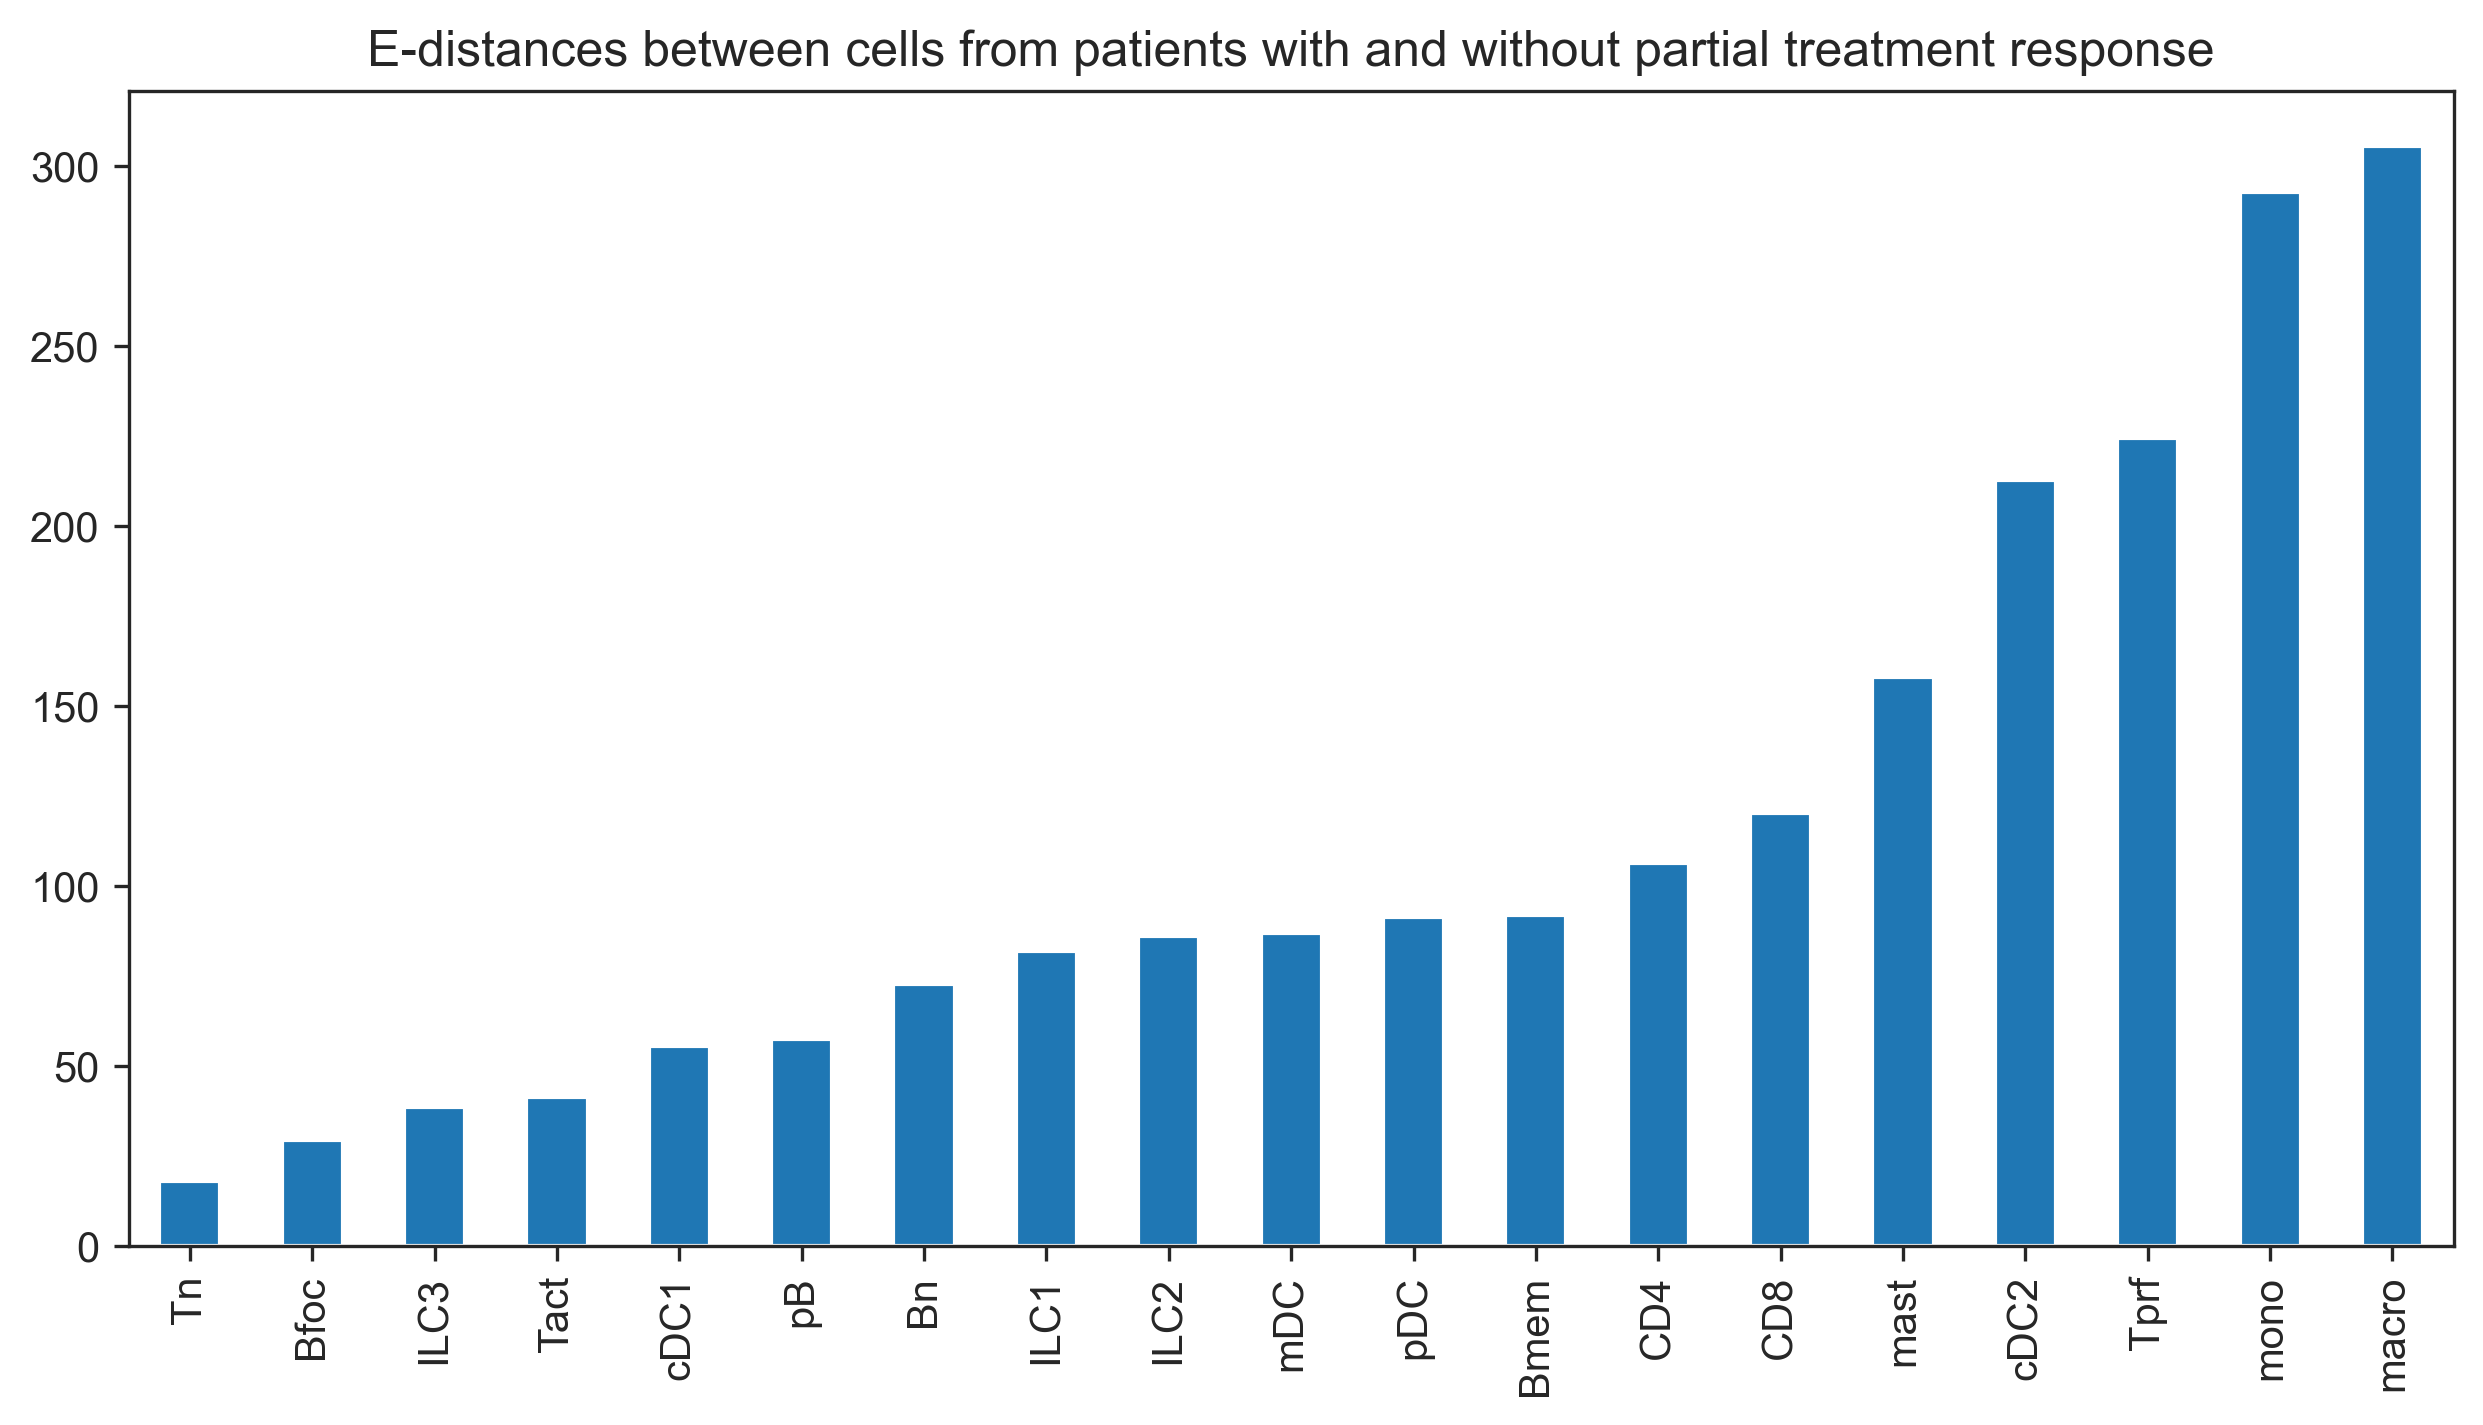

In [99]:
edist_df.sort_values("edist").plot(y = "edist", kind = "bar", figsize = (10,5), legend = False, title = "E-distances between cells from patients with and without partial treatment response")

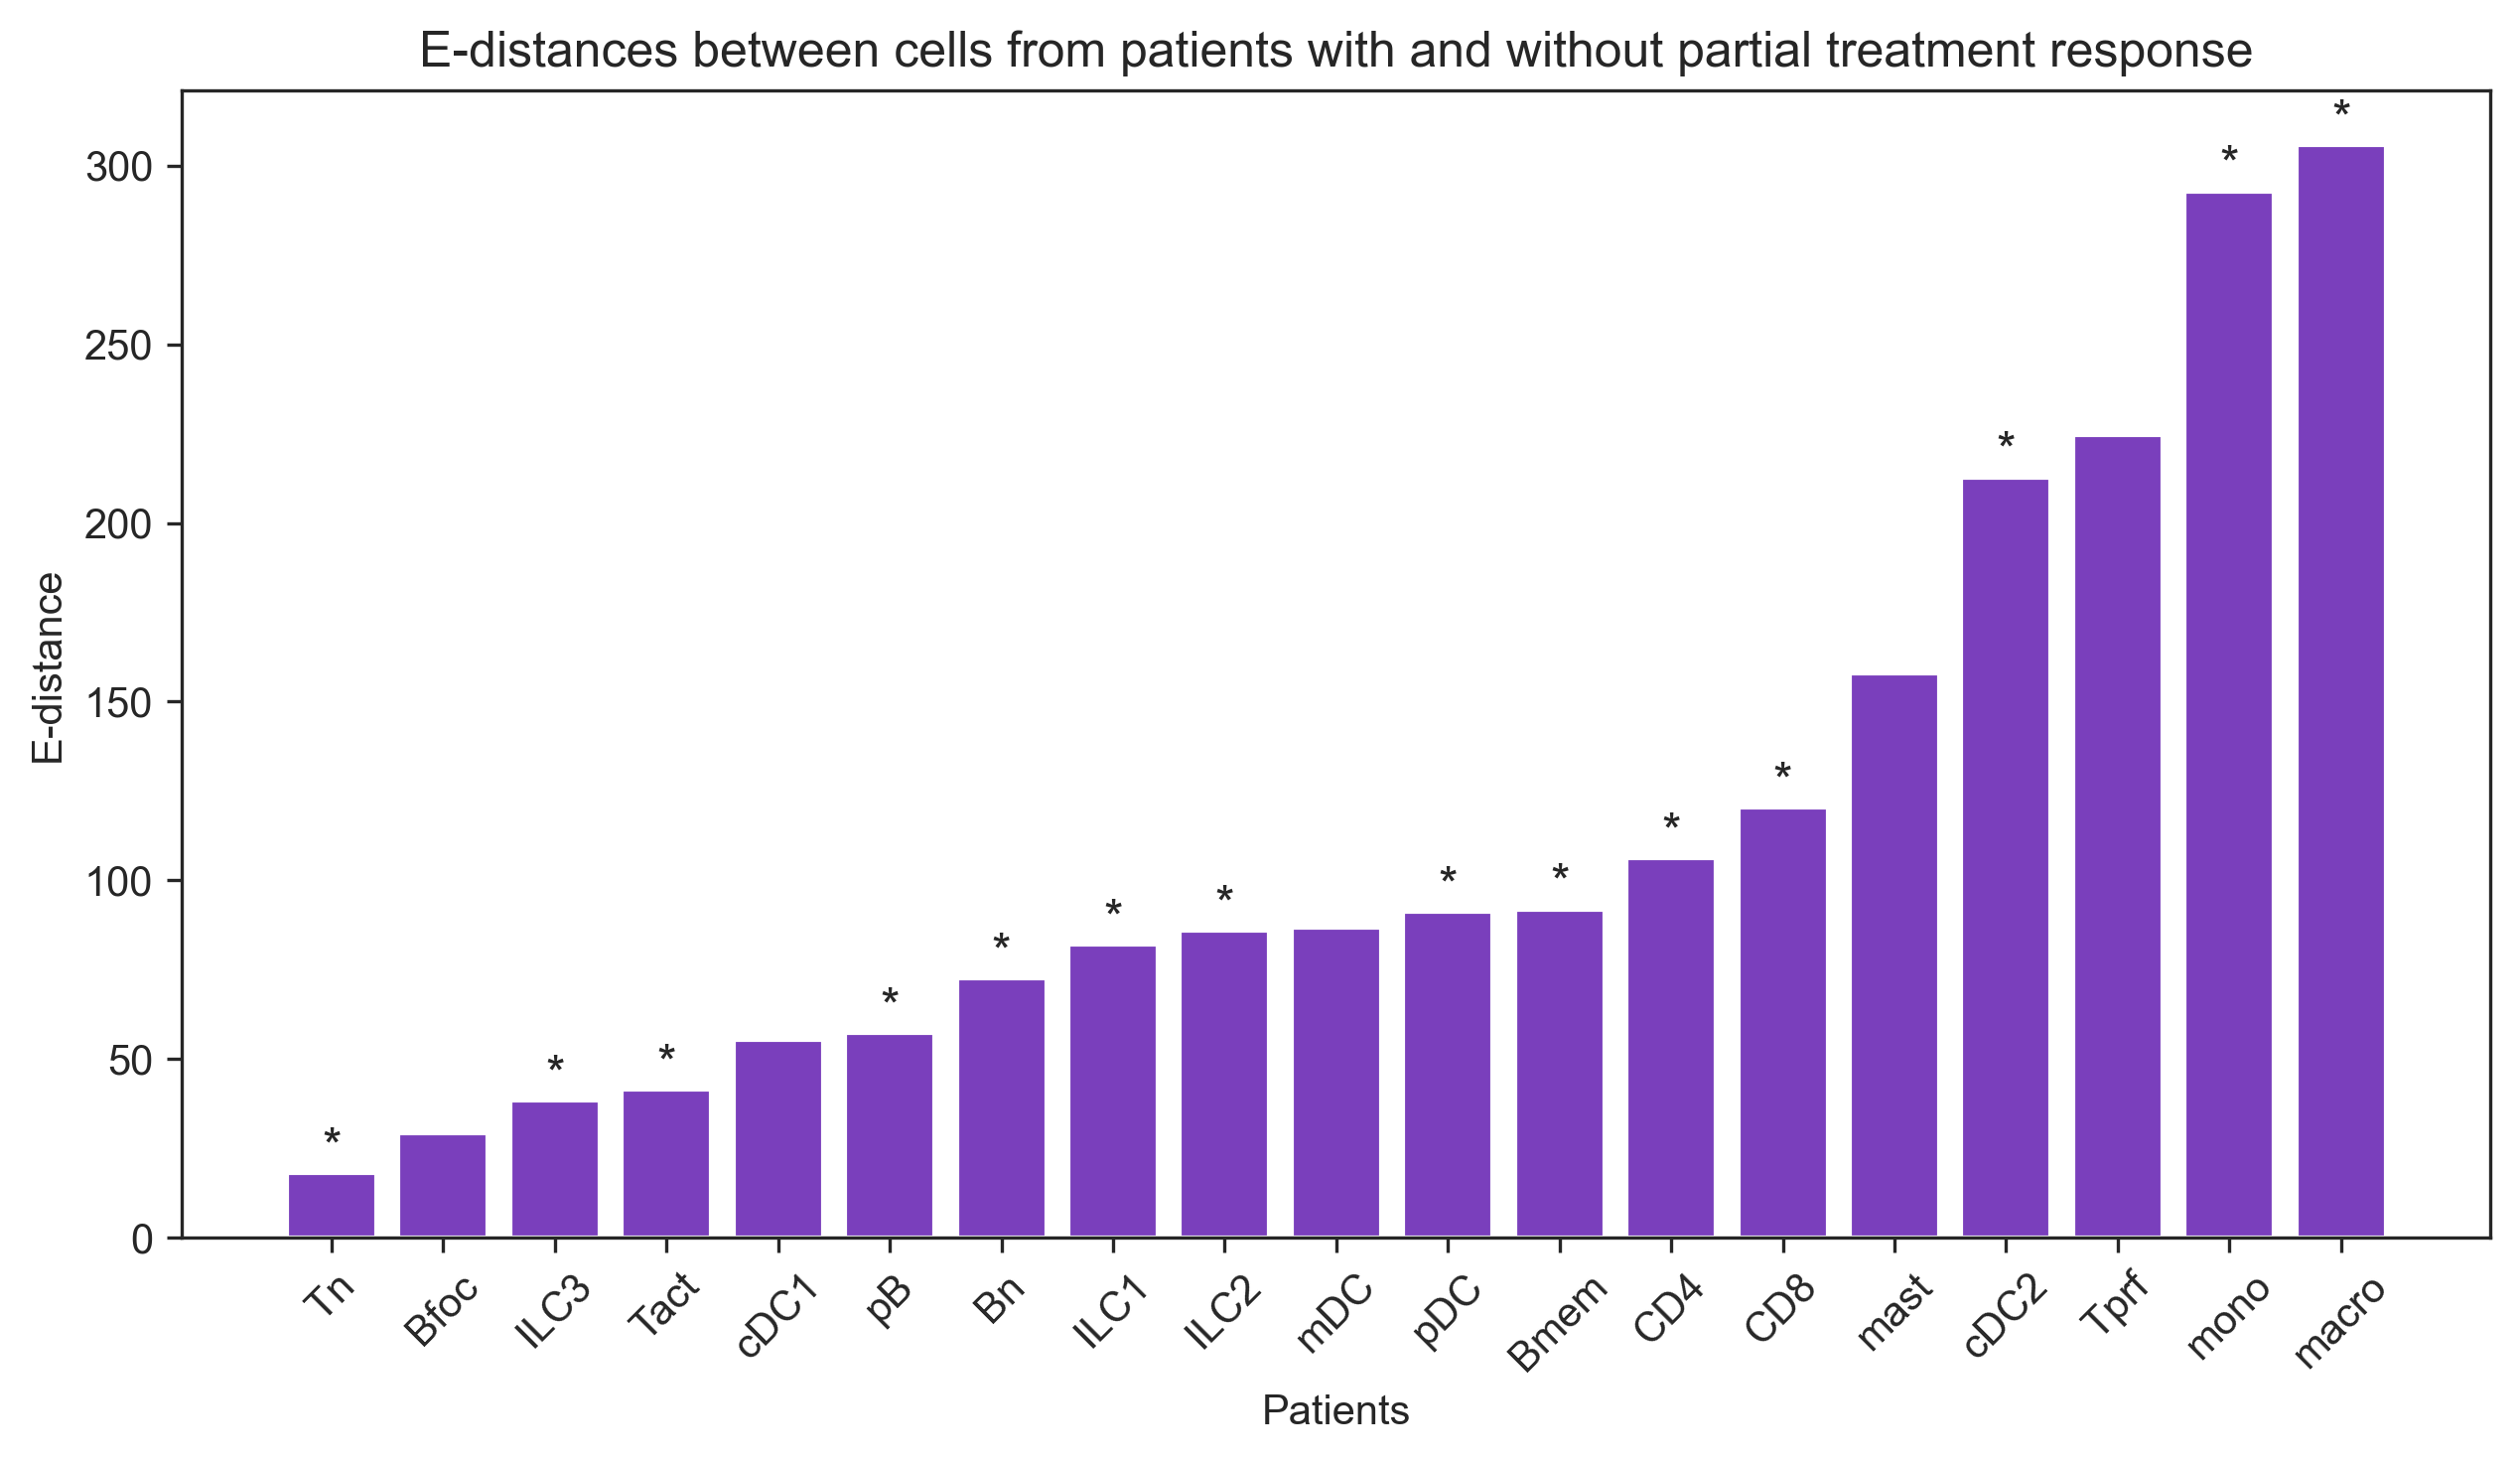

In [113]:
# Sort the DataFrame
edist_df_sorted = edist_df.sort_values("edist")

# Create the bar plot with the desired color
plt.figure(figsize=(10, 5))
plt.bar(edist_df_sorted.index, edist_df_sorted["edist"], color="#7a3fbc", alpha = )
plt.title("E-distances between cells from patients with and without partial treatment response")
plt.xlabel("Patients")
plt.ylabel("E-distance")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

sig_cts = edist_df_sorted[edist_df_sorted['pvalue']<0.01].index.values

# Add asterisks to the top of selected bars
for i in sig_cts:
    plt.text(i, edist_df_sorted.loc[i]["edist"] + 0.005, "*", ha='center', va='bottom', fontsize=12)


# Display the plot
plt.show()

In [111]:
edist_df_sorted['pvalue']<0.01
# get the numbers of the indices that are True


In [115]:
celltype_names = edist_df_sorted.index 
edist_df_sorted['ncells'] = [len(celltype_objs[ct].obs.index) for ct in celltype_names]

In [116]:
edist_df_sorted

edist pvalue  ncells
Tn       18.02271  0.001    2242
Bfoc    29.383396  0.664      42
ILC3    38.451045  0.001     368
Tact    41.390529  0.001     474
cDC1    55.501282  0.099      42
pB      57.309494  0.001    2952
Bn      72.633438  0.001     160
ILC1    81.994536  0.001     378
ILC2    85.976159  0.007      28
mDC     86.828124  0.116      26
pDC     91.256123  0.001     182
Bmem    91.888784  0.001    1262
CD4    106.273327  0.001   14870
CD8    120.301012  0.001   10954
mast   157.995679  0.294       6
cDC2   212.699742  0.001     138
Tprf   224.507548  0.022      10
mono   292.753867  0.001     250
macro  305.627587  0.001    6490